# Preprocesamiento

En esta cuarta etapa se van a tomar decisiones en línea con las estadísticas y análisis con tal de  preparar correctamente los datos que serán parte del entrenamiento y posterior validación de los modelos de predicción.

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nilmtk import DataSet
import warnings
from nilmtk import TimeFrame
warnings. filterwarnings("ignore")
plt.style.use('bmh')



In [3]:
#dataset de referencia 
deps = DataSet('dsual.h5')

elec=deps.buildings[1].elec # Todos los medidores



labels = pd.DataFrame({'Instances': list(range(1,12)),
                       'Meters': ['Main', 'Electric furnace', 'Microwave','Television','Incandescent Lamp','Vacuum cleaner','Electric space heater','Electric shower heater','Fan','Fridge','Freezer']})

Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]

## Cambio en el muestreo de datos e interpolación

Veamos si hay  seccion faltante

In [4]:
tf=elec[1].good_sections(full_results=True).combined()[0]
tf

TimeFrame(start='2023-06-09 09:34:38+02:00', end='2023-06-09 13:36:19+02:00', empty=False)

Muestreo cada 10 segundos, promediando datos (mean) como metodo de relleno y usando el primer dato

In [5]:
ta = '2023-06-09 09:34:38+01:00' #tiempo inicial
tb = '2023-06-09 13:36:19+01:00' #tiempo final

next(elec[1].load(sample_period=10, resample_kwargs={'fill_method':'ffill', 'how': 'first'}))[ta:tb]

physical_quantity              power                     pf     voltage  \
type                        reactive     apparent                         
2023-06-09 10:34:40+02:00  69.007141  3497.072754  0.999789  235.300598   
2023-06-09 10:34:50+02:00  68.846779  3495.531006  0.999791  235.273804   
2023-06-09 10:35:00+02:00  68.085999  3496.225586  0.999794  235.208603   
2023-06-09 10:35:10+02:00  68.472565  3490.410400  0.999794  235.077805   
2023-06-09 10:35:20+02:00   2.955556  1762.101440  0.999354  237.925003   
...                              ...          ...       ...         ...   
2023-06-09 13:35:30+02:00 -12.002560   191.591721  0.919297  245.086609   
2023-06-09 13:35:40+02:00 -12.142139   191.718277  0.918317  244.849197   
2023-06-09 13:35:50+02:00  -2.747426    18.580793  0.567065  245.145599   
2023-06-09 13:36:00+02:00  -2.628904    18.630798  0.570542  245.242599   
2023-06-09 13:36:10+02:00  -2.490698    19.484127  0.582770  245.512405   

physical_quantity                power    current  frequency  
type                            active                        
2023-06-09 10:34:40+02:00  3496.392090  14.862400  49.991699  
2023-06-09 10:34:50+02:00  3494.852051  14.857520  49.985741  
2023-06-09 10:35:00+02:00  3495.562012  14.864580  49.980782  
2023-06-09 10:35:10+02:00  3489.738037  14.848100  49.984322  
2023-06-09 10:35:20+02:00  1762.099976   7.410930  49.991341  
...                                ...        ...        ...  
2023-06-09 13:35:30+02:00   191.215591   0.848687  49.975819  
2023-06-09 13:35:40+02:00   191.333405   0.850942  49.990398  
2023-06-09 13:35:50+02:00    18.375360   0.132160  49.983940  
2023-06-09 13:36:00+02:00    18.439600   0.131754  49.980721  
2023-06-09 13:36:10+02:00    19.321701   0.135074  49.993080  

[1090 rows x 7 columns]

# Obtener los datos del medidor principal  cada 60 segundos.

Además del parámetro sample_period=60, requerido para cambiar el muestreo a un minuto, se ha especificado como método (how) de cambio de muestreo el que provee NILMTK por defecto (mean). En el mismo diccionario resample_kwargs se ha especificado el parámetro fill_method el cual corresponderá al método elegido para rellenar los huecos. En este caso se especifica el método ffill el cual, ante un hueco, rellenará los datos faltantes hacia adelante con el valor inmediatamente anterior a la serie de tiempo

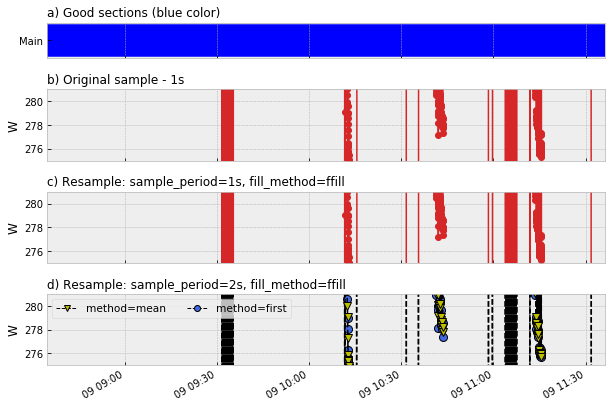

In [6]:
rcParams['figure.figsize'] = (10, 7)



#contador principal
Main=elec.select(instance=[1])

#definición de  gráficas
fig, (ax4, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True,
                                         gridspec_kw={'hspace': 0.5,'height_ratios':[1.5, 3, 3, 3]})


#sample a segundo
elec[1].power_series_all_data()[ta:tb].plot(ax=ax1, color='tab:red', marker="o", lw=1.5)
ax1.minorticks_off()
ax1.set_ylabel('W')
ax1.set_title('b) Original sample - 1s', fontsize=12, loc='left')

ax1.set_ylim(275,281)


#sample a 1 segundo metodo fill
elec[1].power_series_all_data(sample_period=1, resample_kwargs={'fill_method': 'ffill'})[ta:tb].plot(ax=ax2, marker="o", color='tab:red',lw=1.5)
ax2.minorticks_off()
ax2.set_ylabel('W')
ax2.set_title('c) Resample: sample_period=1s, fill_method=ffill', fontsize=12, loc='left')

ax2.set_ylim(275,281)



#sample a 2 segundos metodo fill
elec[1].power_series_all_data(sample_period=4,resample_kwargs={'how': 'first'})[ta:tb].plot(ax=ax3, color='k', lw=1.5, ls='--', marker="o",
                                                           markersize=8, markerfacecolor='royalblue')
elec[1].power_series_all_data(sample_period=4, resample_kwargs={'how': 'mean'})[ta:tb].plot(ax=ax3, color='k', lw=1.5, ls='--', marker="v",
                          markersize=8, markerfacecolor='y')
ax3.minorticks_off()
ax3.set_ylabel('W')
ax3.set_title('d) Resample: sample_period=2s, fill_method=ffill', fontsize=12, loc='left')
ax3.set_ylim(275,281)


#good sections
import matplotlib.lines as mlines
line1 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="o", markersize=6, markerfacecolor='royalblue', label='method=first')
line2 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="v", markersize=6, markerfacecolor='y', label='method=mean')
ax3.legend(handles=[line2, line1], fontsize=10.5, ncol=2)
ax4=Main.plot_good_sections(ax=ax4)
ax4.set_yticklabels(list(Meters.values()))
ax4.grid(axis='y')
ax4.set_title('a) Good sections (blue color)', fontsize=12, loc='left')

#guarda gráfico
plt.savefig('./data/images/3.1_Prepros_1.svg', bbox_inches='tight', transparent=True)
pass

## Filtros de dispositivos eléctricos

Vamos a filtrar por aquellos dispositivos cuya potencia activa sea superior a 5,85kwh

In [7]:
Devices=elec.select(instance=[2,3,4,5,6,7,8,9,10,11]) #MeterGroup de dispositivos
d=Devices.energy_per_meter().loc['active']  #energía kWh
d[d>5.85] #filtra dispositivos menores o iguales a 5.85 kWh (5% consumo)

10/10 ElecMeter(instance=11, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])instance=1)])

Series([], Name: active, dtype: float64)

Vemos  el top-k entre los dispositivos electricos conectados

In [8]:
Devices = elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
Devices.select_top_k(k=5)

10/10 ElecMeter(instance=11, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])instance=1)])

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=8, building=1, dataset='DSUAL', appliances=[Appliance(type='electric shower heater', instance=1)])
  ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='microwave', instance=1)])
)

## División del dataset

- train: conjunto de datos de entrenamiento de modelos de desagregación
- test: conjunto de datos de validación y pruebas de modelos de desagregación

Entrenamiento:

In [10]:
train = DataSet('dsual.h5')

train.set_window(start="2023-06-09 09:34:00", end="2023-06-09 12:54:00")

train_elec=train.buildings[1].elec

train_elec.get_timeframe()

TimeFrame(start='2023-06-09 09:34:38+02:00', end='2023-06-09 12:54:00+02:00', empty=False)

In [ ]:
train_elec.plot()
#no hay datos train_elec.submeters().plot()



Validación:

In [11]:
 #Validación 

valid = DataSet('dsual.h5')

valid.set_window(start="2023-06-09 12:55:00", end="2023-06-09 13:36:00")

valid_elec=valid.buildings[1].elec

valid_elec.get_timeframe()

TimeFrame(start='2023-06-09 12:55:00+02:00', end='2023-06-09 13:36:00+02:00', empty=False)

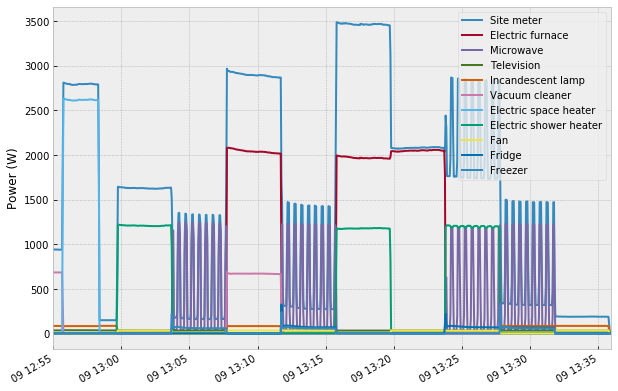

In [12]:
valid_elec.mains().plot()
valid_elec.submeters().plot()

Pruebas

In [15]:
test = DataSet('dsual_test.h5') #Pruebas

test.set_window(start="2023-06-06 11:19:19", end="2023-06-06 11:40:28")

test_elec=test.buildings[1].elec

test_elec.get_timeframe()

TimeFrame(start='2023-06-06 11:19:19+02:00', end='2023-06-06 11:40:28+02:00', empty=False)

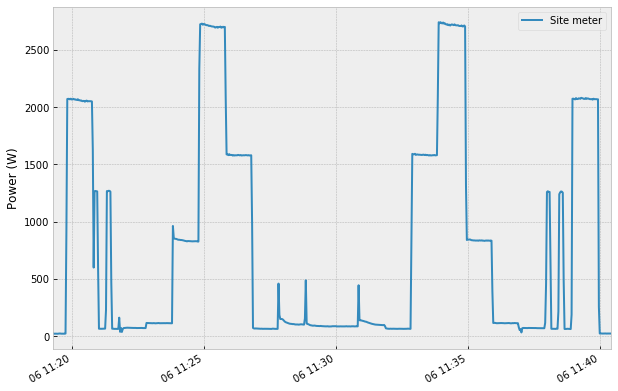

In [16]:
test_elec.mains().plot()